
# Exploring game mobile app data

**Задачи:**
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.  
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.  

**Data provided:** 
* `problem1-reg_data.csv` - data on the time of registration
* `problem1-auth_data.csv` - data on the time users entered the game 
* `problem2.csv` – A/B test results

## Stages of project execution

1. [Показатель Retention](#1.-Показатель-Retention)  
   - [1.1 Задача](#1.1-Задача)
   - [1.2 Загрузка данных](#1.2-Загрузка-данных)
   - [1.3 Предобработка данных](#1.3-Предобработка-данных)
   - [1.4 Расчет Retention](#1.4-Расчет-Retention)
   - [1.5 Результаты](#1.5-Результаты)
2. [A/B тестирование](#2.-A/B-тестирование)
   - [2.1 Задача](#2.1-Задача)
   - [2.2 Загрузка данных](#2.2-Загрузка-данных)
   - [2.3 Предобработка данных](#2.3-Предобработка-данных)
   - [2.4 Проверка гипотез](#2.4-Проверка-гипотез)
   - [2.5 Результаты](#2.5-Результаты)
3. [Набор метрик для оценки результатов](#3.-Набор-метрик-для-оценки-результатов)
   - [3.1 Задача](#3.1-Задача)
   - [3.2 Набор метрик](#3.2-Набор-метрик)
   - [3.3 Результаты](#3.3-Результаты)
4. [Результаты исследования](#4.-Результаты-исследования)

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm

%matplotlib inline

## 1. Retention indicator

### 1.1 Task


**Retention** is one of the most important indicators in a company. Your task is to write a function that will count the retention of players (by days from the date of registration of the player).

### 1.2 Loading data

#### Registration time data

In [2]:
# reading data file with saving in reg
reg = pd.read_csv('problem1-reg_data.csv', sep=';')

Getting the first 10 rows of a table.

In [3]:
#Getting the first 10 rows of a table..
reg.head(10)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5
5,977206495,6
6,984222671,7
7,990407778,8
8,995943765,9
9,1000951674,10


General information about table data reg.

In [4]:
# getting general information about the data in the reg table
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


Let's consider the received information in more detail.

In total, the table has 2 columns and 1,000,000 rows. There is one data type: int64.

Let's take a closer look at which columns in reg contain what information:
* reg_ts - registration time in Unix timestamp format
* uid - unique identifier (user id)

The number of values ​​in the columns is the same, there are no missing values.

#### Data on when users entered the game

In [5]:
# reading data file with saving in auth
auth = pd.read_csv('problem1-auth_data.csv', sep=';')

In [6]:
#Getting the first 10 rows of a table.
auth.head(10)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2
5,934372615,2
6,934662633,2
7,935002586,2
8,935141232,2
9,935682752,2


General information about the auth table data.

In [7]:

auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [8]:
# check for missing values.
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [9]:
# get the number of rows in the table
auth.shape[0]

9601013

In total, the table has 2 columns and 9601013 rows. There is one data type: int64.

Let's take a closer look at which columns in auth contain which information:
* auth_ts - time the user entered the game in Unix timestamp format
* uid - unique identifier (user id)

The number of values ​​in the columns is the same, there are no missing values.

#### Conclusions

Each row of the table contains the user's id and a timestamp of his action (registration or the time he entered the game). There are no gaps in the data.

The next step will be:
* convert timestamps from Unix timestamp format,
* convert uid to string format (eliminate potential loss of zeros and further possible problems, though at the expense of some insignificant loss in the efficiency of working with data for a given amount of data),
* examine the data for anomalies (for example, registrations with the re-assignment of an already used uid, abnormal frequency of users entering the game (cut off bots), etc.)

### 1.3 Data preprocessing

Let's do a timestamp conversion, convert the uid to a string format, and examine the data for anomalies.

#### Registration time data

**Let's convert the timestamp column from Unix timestamp to datetime.**

In [10]:
# do the transformation
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s')

In [12]:
# see the results of the conversion
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


Let's get acquainted with the distribution of the date range.

In [13]:
# see descriptive statistics
reg.reg_ts.describe(include='all', datetime_is_numeric=True)

count                          1000000
mean     2019-01-24 12:12:34.523666688
min                1998-11-18 09:43:43
25%         2018-06-03 13:55:11.500000
50%                2019-07-30 02:35:25
75%      2020-04-01 16:28:40.499999744
max                2020-09-23 15:17:24
Name: reg_ts, dtype: object

We see that the full date range has values ​​from 1998-11-18 to 2020-09-23. 

Let's check the percentage of the number of registrations in a given year.

In [14]:
# group the data by years and calculate the number of registrations as a percentage
reg_by_year = reg.reg_ts.dt.year.value_counts(normalize=True) \
                 .reset_index() \
                 .rename(columns={'index': 'year', 'reg_ts': 'regs_pct'}) 

In [15]:
# look at years with more than one percent registrations
reg_by_year[reg_by_year['regs_pct'] >= 0.01]

,year,regs_pct
0,2020,0.354963
1,2019,0.291102
2,2018,0.159729
3,2017,0.087645
4,2016,0.048187
5,2015,0.026344
6,2014,0.014455


We will continue to work with data starting from 2014. The remaining data will be considered outliers and excluded from the table.

In [16]:
# save data to reg_14 variable
reg_14 = reg[reg.loc[:, 'reg_ts'] > '2014-01-01 00:00:00.000000000']

In [17]:
# reset indexes
reg_14.reset_index(inplace=True, drop=True)

In [18]:
# see descriptive statistics
reg_14.reg_ts.describe(include='all', datetime_is_numeric=True)

count                           982425
mean     2019-03-09 11:11:10.245498112
min                2014-01-01 00:03:11
25%                2018-07-04 19:51:14
50%                2019-08-09 16:52:29
75%                2020-04-05 05:43:58
max                2020-09-23 15:17:24
Name: reg_ts, dtype: object

In [19]:
# see the number of cut lines
reg.shape[0] - reg_14.shape[0]

17575

In [20]:
# number of cut lines as a percentage
round((reg.shape[0] - reg_14.shape[0]) * 100 / reg.shape[0], 2)

1.76

We see that the data before 2014 were cut off (17575 rows or 1.76%).

**Convert uid values ​​to string data format**

In [21]:
# convert the data type of the uid column to string values
reg_14.loc[:, ['uid']] = reg_14['uid'].astype('str')

C:\Users\Nikhil\anaconda3\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
# check the correctness of the conversion
reg_14.dtypes

reg_ts    datetime64[ns]
uid               object
dtype: object

Converting uid to string format was successful.

**Check for user registrations with re-assignment of an already used uid**

In [23]:
# display the number of duplicate uids encountered
reg_14.uid.duplicated().sum()

0

No reuse of uids already issued.

#### Data on when users entered the game

**Let's convert the timestamp column from Unix timestamp to datetime.**

In [24]:
# do the transformation
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit='s')

In [25]:
# see the results of the conversion
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


Let's get acquainted with the distribution of the date range.

In [26]:
# see descriptive statistics
auth.auth_ts.describe(include='all', datetime_is_numeric=True)

count                          9601013
mean     2019-01-29 16:12:06.254851584
min                1998-11-18 09:43:43
25%                2018-06-07 12:40:47
50%                2019-07-31 12:43:16
75%                2020-04-02 10:25:21
max                2020-09-23 15:17:24
Name: auth_ts, dtype: object

We see that the full date range has values ​​from 1998-11-18 to 2020-09-23.

As for the case with registrations, we will leave only the values ​​\u200b\u200bstarting from 2014. The remaining data will be considered outliers and excluded from the table.

In [27]:
# store the data in the auth_14 variable
auth_14 = auth[auth.loc[:, 'auth_ts'] > '2014-01-01 00:00:00.000000000']

In [28]:
# сбросим индексы
auth_14.reset_index(inplace=True, drop=True)

In [29]:
# see descriptive statistics
auth_14.auth_ts.describe(include='all', datetime_is_numeric=True)

count                          9445996
mean     2019-03-10 11:48:49.205444608
min                2014-01-01 00:03:11
25%         2018-07-05 22:59:18.500000
50%                2019-08-10 05:59:40
75%      2020-04-05 16:38:24.249999872
max                2020-09-23 15:17:24
Name: auth_ts, dtype: object

In [29]:
# see the number of cut lines
auth.shape[0] - auth_14.shape[0]

155017

In [30]:

# number of cut lines as a percentage
round((auth.shape[0] - auth_14.shape[0]) * 100 / auth.shape[0], 2)

1.61

We see that the data before 2014 were cut off (155017 rows or 1.61%).

**Convert uid values ​​to string data format**

In [31]:
# convert the data type of the uid column to string values
auth_14.loc[:, ['uid']] = auth_14['uid'].astype('str')

In [32]:
# check the correct execution
auth_14.dtypes

auth_ts    datetime64[ns]
uid                object
dtype: object

Converting uid to string format was successful.

**Study the statistics of user visits to the game**

In [33]:
# grouping by users and counting the number of visits to the game
auth_freq = auth_14.groupby('uid', as_index=False) \
                   .agg({'auth_ts': 'count'}) \
                   .rename(columns={'auth_ts': 'visits'}) \
                   .sort_values('visits', ascending=False)

In [34]:
# descriptive statistics of the distribution of the number of user visits to the game
auth_freq.visits.describe()

count    983392.000000
mean          9.605525
std          45.489029
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         647.000000
Name: visits, dtype: float64

The maximum number of visits to the game is very different from the average and median values. Let's check the time between visits to exclude bot visits.

In [35]:
# grouping by users and sorting by entry time
auth_14_delta = auth_14.reset_index() \
                       .groupby(['index', 'uid', 'auth_ts'], as_index=False) \
                       .agg({'index': 'count'}) \
                       .drop(columns='index') \
                       .sort_values(['uid', 'auth_ts'])

In [36]:
# calculate the time difference between visits
auth_14_delta['delta'] = auth_14_delta.auth_ts.diff(periods=1)

auth_14_delta

,uid,auth_ts,delta
690733,100000,2016-09-20 02:33:46,NaT
8485653,1000000,2020-07-21 19:58:14,1400 days 17:24:28
8485662,1000001,2020-07-21 19:59:12,0 days 00:00:58
8553022,1000001,2020-07-26 12:14:31,4 days 16:15:19
8593456,1000001,2020-07-29 07:45:01,2 days 19:30:30
...,...,...,...
9097164,999999,2020-09-01 04:42:45,3 days 12:16:06
9151803,999999,2020-09-04 18:14:23,3 days 13:31:38
9231540,999999,2020-09-09 22:14:16,5 days 03:59:53
9328627,999999,2020-09-16 03:59:54,6 days 05:45:38


In [37]:
# remove everyone who has less than 5 minutes between sessions
# (possible bots and users who didn't play / random logins)
auth_14_delta = auth_14_delta[auth_14_delta['delta'] >= '0 days 00:05:00']

In [38]:
# create a list of "normal" users (not bots and not random visits)
active_uids = auth_14_delta.uid.unique()

In [40]:
# remove the uid with the abnormal number of visits to the game from auth_14
auth_14_cleaned = auth_14.query('uid in @active_uids')

In [41]:

# see the number of cut lines
auth_14.shape[0] - auth_14_cleaned.shape[0]

645083

In [42]:
# number of cut lines as a percentage
round((auth_14.shape[0] - auth_14_cleaned.shape[0]) * 100 / auth_14.shape[0], 2)

6.83

645083 anomalous strings were discarded (by the frequency of entering the game), which is 6.83%.


#### Conclusions

The data formats were changed (Unix timestamp --> datetime; uid from integer to string values), checking for duplicate uid values ​​​​after registration (no duplicates were found), deleting data that was not date-relevant (left data from 2014), as well as the search and removal of anomalous values ​​by the frequency of entering the game (removed about 7% of the data - possibly bots or random user entries into the game, without the game process itself).

The next step is to calculate user retention.

### 1.4 Retention Calculation

#### Data preparation#### Подготовка данных

Let's calculate the retention (retention level) of players by days from the date of registration of the player.

In [43]:
# merge tables into one dataframe by uid
data = auth_14_cleaned.merge(reg_14, how='left', on='uid')

data

,auth_ts,uid,reg_ts
0,2014-01-01 00:04:58,5460,NaT
1,2014-01-01 00:07:08,14320,NaT
2,2014-01-01 00:07:40,584,NaT
3,2014-01-01 00:11:19,17025,NaT
4,2014-01-01 00:12:46,5939,NaT
...,...,...,...
8800908,2020-09-23 14:36:14,1110570,2020-09-23 14:36:14
8800909,2020-09-23 14:43:15,1110580,2020-09-23 14:43:15
8800910,2020-09-23 14:50:15,1110591,2020-09-23 14:50:15
8800911,2020-09-23 14:58:08,1110600,2020-09-23 14:58:08



Users were found with login time but no login time. Let's look at the total number of such users.

In [44]:
# Determine the number of rows without logging time values
data.reg_ts.isna().sum()

520363

We will remove such users from the data, because it will not be possible to build retention on them from the date of registration.

In [45]:
# remove users without registration time
data.dropna(subset=['reg_ts'], inplace=True)

In [46]:

# reset the index
data.reset_index(drop=True, inplace=True)

In [47]:
# see the number of cut lines
auth_14_cleaned.shape[0] - data.shape[0]

520363

In [48]:
# number of cut lines as a percentage
round((auth_14_cleaned.shape[0] - data.shape[0]) * 100 / auth_14_cleaned.shape[0], 2)

5.91


520363 rows were discarded without log times, which is 5.91%.


#### Retention calculation function

Let's write a function to calculate retention by day.


In [49]:

# function for calculating retention by day
def retention(data, reg_pos=2, auth_pos=0, uid_pos=1, min_date=None, max_date=None):
    '''Calculates retention by days from the date of user registration.

    Parameters
    ----------
    data : data frame
        Dataframe with data.
    reg_pos : int
        Column number in the dataframe containing the registration time
        (default is 2)
    auth_pos : int
        Column number in the dataframe containing the entry time
        (default is 0)
    uid_pos : int
        Column number in the dataframe containing the user's uid
        (default is 1)
    min_date : str
        Minimum registration date in 'yyyy-mm-dd' format (including)
        (default is None)
    max_date : str
        Maximum registration date in 'yyyy-mm-dd' format (not including)
        (default is None)

    returns
    -------
    data frame
        Retention table
    '''

 # make a selection of the desired columns
    df = data.iloc[:, [uid_pos, reg_pos, auth_pos]].copy(deep=True)
    
 # checking for availability and determining the min_date parameter
    if min_date is None:
        min_date = df.reg_ts.min()
        
   # checking for availability and determining the max_date parameter
    if max_date is None:
        max_date = df.reg_ts.max()       

  # put the dates of registration and entry into the application into separate columns
    df['date_reg'] = df.reg_ts.dt.date
    df['date_auth'] = df.auth_ts.dt.date
    
    # make a selection by date range
    df = df[(df['reg_ts'] >= min_date) & (df['reg_ts'] <= max_date)]
    
  
    # count the number of days between the date of registration and the entrance to the application
    df['days'] = df['date_auth'] - df['date_reg']
    
    # group by the days of registration and the number of days of use
    cohorts = df.groupby(['date_reg', 'days'], as_index=False) \
                  .agg({'uid': 'nunique'})  # aggregate by unique users
    # create a pivot table
    cohorts_pivot = cohorts.pivot(index='date_reg', columns='days', values='uid')
    
    # calculate retention
    retention = pd.DataFrame()  # empty dataframe to which we will add row by row
    for i in range(cohorts_pivot.shape[0]):  # iterate over rows
        a = cohorts_pivot.iloc[i, 0]  # 100% number of users for this date
        temp = cohorts_pivot.iloc[i, :].divide(a, axis=0).round(4)  #get a percentage conversion
        retention = retention.append(temp)  # add the calculated values ​​row by row to the final retention table

    return retention

#### Функция отображения посчитанного retention

Let's write a function to visualize the retention table.

In [57]:
# function to build the retention table
def plot_retention(data, product_lt=10, user_lt=10, savefig=False):
     
    # select the desired data segment for output
    user_lt_lst = [_ for _ in range(user_lt)]
    plotting_slice = data.iloc[:product_lt, user_lt_lst]
   # drawing the retention table and its design (title, axes, etc.)
    plt.figure(figsize=(16,9))
    ax = sns.heatmap(data=plotting_slice, fmt=' .2%', cmap='Blues', annot=True)
    ax.set_title('Retention Heatmap',fontsize= 18)
    xlabels = [f'Day {i}' for i in range(user_lt)]
    ax.set_xticklabels(xlabels, rotation=0)
    ax.xaxis.tick_top()
   
     
    
  # save the heatmap as a jpeg in the working directory
    if savefig == True:
        start = plotting_slice.index[0].strftime('%y%m%d')
        end = plotting_slice.index[plotting_slice.shape[0]-1].strftime('%y%m%d')
        plt.savefig(f'retention_{start}_{end}.jpg')

#### Проверка результатов работы функций

Проверим работу написанных функций и построим heatmap retention для периода с 01.09.2020 по 23.09.2020.

In [50]:
# посчитаем retention
retention_test = retention(data, min_date='2020-09-01', max_date='2020-09-24')

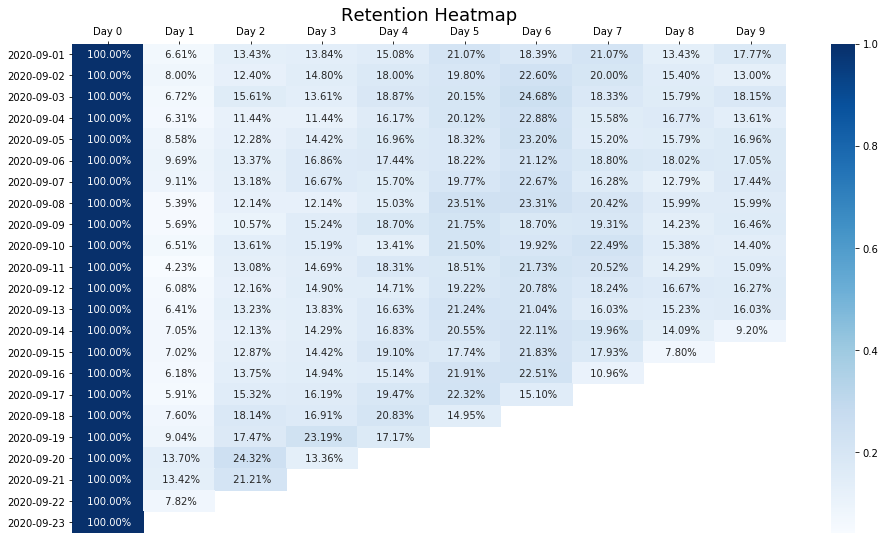

In [51]:
# построим heatmap с сохранением результата в jpg файл
plot_retention(retention_test, product_lt=23, user_lt=10, savefig=True)

The retention calculation and display functions work correctly.

### 1.5 Results

At this stage, two functions were written and documented: calculation and display of the retention table. With the help of function parameters, it is possible to set the range of retention calculation and display dates, as well as give a command to save the final retention table 
The retention indicator is very important. It can be used to judge the user's involvement in the product, as well as track and predict the dynamics of his behavior. For example, on the September 2020 test data, we see that the user generally starts returning to the game on the second day after registration (registration in this case is day zero). The maximum retention of users occurs on 4-7 days of using the product, after which the retention rate begins to fall. In this regard, it is worth considering promotions and / or new game mechanics that allow you to increase user retention even after the seventh day of using the game from the moment of user registration.

## 2. A/B testing

### 2.1 Task

There are results of an A / B test in which two groups of users were offered different sets of promotional offers. It is known that ARPU in the test group is 5% higher than in the control group. At the same time, in the control group, 1928 out of 202103 players turned out to be paying, and in the test group - 1805 out of 202667.

What set of proposals can be considered the best? What metrics should be analyzed to make the right decision and how?


### 2.2 Loading data

Let's examine the available data.

Read the `problem2.csv` file and store it in the ab variable.

In [58]:
# reading a data file with saving in ab
ab = pd.read_csv('problem2.csv', sep=';')

Getting the first 10 rows of a table.

In [59]:
# get the first 10 rows of the table
ab.head(10)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
7,8,0,b
8,9,0,b
9,10,0,a


General information about table data ab.

In [60]:

ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


Let's consider the received information in more detail.

In total, the table has 3 columns and 404770 rows. There are two data types: int64 (user_id, revenue) and object (testgroup).

Let's take a closer look at which columns in ab contain which information:
* user_id - user identifier (user id)
* revenue - revenue per user
* testgroup - belonging to a control or test group.

The number of values ​​in the columns is the same, there are no missing values.

#### Conclusion

Each row of the table contains the user id, the revenue received from him and the flag of belonging to the control or test group. There are no gaps in the data.

The next step will be:
* convert user_id to string format (eliminate potential loss of zeros and further possible problems associated with this)
* check for duplicate user_id values
* check the operation of the split system
* Examine data for anomalies (e.g. negative revenues, outliers in revenues, etc.)
* test for normal distribution and homogeneity of variances
* decide on the choice of a statistical criterion for testing hypotheses.

### 2.3 Data preprocessing

**Convert user_id values ​​to string data format**

In [61]:

ab['user_id'] = ab['user_id'].astype('str')

In [62]:
# check the correct execution
ab.dtypes

user_id      object
revenue       int64
testgroup    object
dtype: object

Converting user_id to string format was successful.

**Check for duplicate user_id values**

In [63]:

ab.user_id.duplicated().sum()

0

Повторного использования user_id не обнаружено.

**Let's check the uniformity of the distribution of users into the control and test groups**

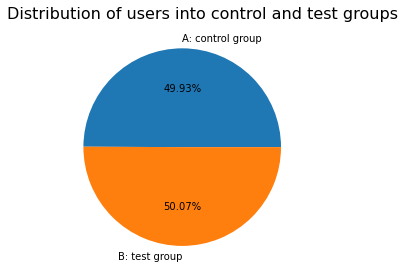

In [64]:
# grouping by groups
ab_counts = ab.groupby('testgroup').count().reset_index()
# drawing distribution results

plt.pie(ab_counts.revenue, labels=['A: control group', 'B: test group'], autopct='%0.2f%%')
plt.figtext(.56, .95,'Distribution of users into control and test groups', fontsize=16, ha='center')
plt.axis('equal');

The split system worked correctly. We have almost equal number of user groups.

**Take a look at descriptive revenue statistics by group**

In [65]:
# splitting into groups and counting statistics
a = ab[ab['testgroup'] == 'a'].revenue.describe()
b = ab[ab['testgroup'] == 'b'].revenue.describe()

In [66]:
# collate into one table
revenue_stats = pd.concat([a, b], axis=1, keys=['revenue A', 'revenue B'])

revenue_stats

,revenue A,revenue B
count,202103.000000,202667.000000
mean,25.413720,26.751287
std,920.768137,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,37433.000000,4000.000000


No negative earnings were found. The maximum values ​​and standard deviations of the samples vary greatly.Отрицательных значений выручки не обнаружено. Максимальные значения и стандартные отклонения выборок сильно различаются.

In [82]:
# calculating the percentage of average revenue
rev_dif = ab[ab['testgroup'] == 'b'].revenue.mean() / ab[ab['testgroup'] == 'a'].revenue.mean()

# automation of the difference sign of the average revenue when printing
if rev_dif - 1 > 0:
    sign = '+'
else:
    sign = ''

print(f'Average revenue in group B differs by {sign}{rev_dif - 1:.2%} from the average revenue in group A.')

Average revenue in group B differs by +5.26% from the average revenue in group A.


We will test this difference for statistical significance.

Let's take a closer look at the distribution of revenue values ​​within groups.

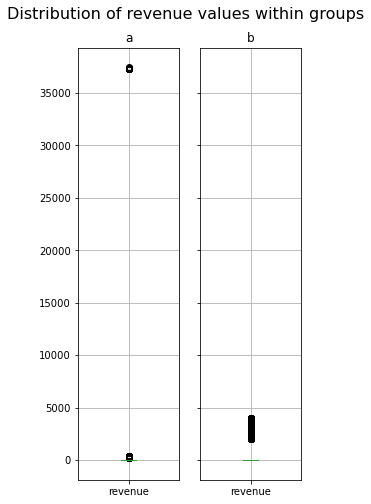

In [83]:
# building a boxplot chart (for revenue)
ab.groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .95,'Distribution of revenue values ​​within groups', fontsize=16, ha='center');

In group A, in the region of 37000, a group of anomalous values ​​is concentrated.

Let's look at the distribution of values ​​(descriptive statistics) for paying users

In [84]:
# splitting into groups and counting statistics
a_paid = ab[(ab['testgroup'] == 'a') & (ab['revenue'] > 0)].revenue.describe()
b_paid = ab[(ab['testgroup'] == 'b') & (ab['revenue'] > 0)].revenue.describe()

In [85]:
# collate into one table
revenue_paid_stats = pd.concat([a_paid, b_paid], axis=1, keys=['revenue A', 'revenue B'])

revenue_paid_stats

,revenue A,revenue B
count,1928.000000,1805.000000
mean,2663.998444,3003.658172
std,9049.039763,572.619709
min,200.000000,2000.000000
25%,257.000000,2513.000000
50%,311.000000,3022.000000
75%,361.000000,3478.000000
max,37433.000000,4000.000000


The groups are very different in most respects. The standard deviations differ by almost 16 times. The median values ​​of the groups differ by about 10 times. 

Let's take a closer look at the distribution of revenue values ​​within groups for paying users.

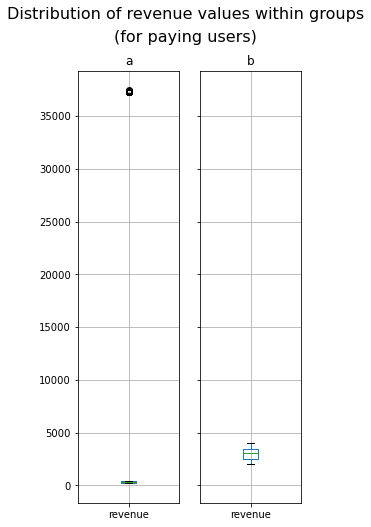

In [86]:
# building a boxplot chart (for revenue)
ab[ab['revenue'] > 0].groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .99,'Distribution of revenue values ​​within groups', fontsize=16, ha='center');
plt.figtext(.35, .95,'(for paying users)', fontsize=16, ha='center');

In group A, in the region of 37000, a group of anomalous values ​​is concentrated. It looks like it's an outlier. Possibly related to a logging error (all these abnormal values ​​are approximately 37000 more than the median values ​​of group A). Either users from the "ultra-premium" segment got into group A, and such users did not get into group B, then this will indicate the incorrect operation of the splitting system. It will be necessary to deal with these users separately when we have additional information on them (send a request).

For now, let's get rid of these emissions.

In [87]:
# write values ​​without outliers to a new variable
ab_clean = ab.query('revenue < 5000')  # border 5000 determined by the previous boxplot

In [88]:
# reset the index
ab_clean.reset_index(drop=True, inplace=True)

In [89]:
# see the number of cut lines
ab.shape[0] - ab_clean.shape[0]

123

In [90]:
# number of cut lines as a percentage
round((ab.shape[0] - ab_clean.shape[0]) * 100 / ab.shape[0], 2)

0.03

123 lines with abnormal revenue values ​​were discarded, which is 0.03% of the total number of lines.

**Take a look at descriptive revenue statistics by group (data without outliers)**

In [91]:
# splitting into groups and counting statistics
a_clean = ab_clean[ab_clean['testgroup'] == 'a'].revenue.describe()
b_clean = ab_clean[ab_clean['testgroup'] == 'b'].revenue.describe()

In [92]:
# collate into one table
revenue_stats_clean = pd.concat([a_clean, b_clean], axis=1, keys=['revenue A', 'revenue B'])

revenue_stats_clean

,revenue A,revenue B
count,201980.000000,202667.000000
mean,2.702926,26.751287
std,28.985815,287.324162
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,400.000000,4000.000000


No negative earnings were found. The maximum values ​​and standard deviations of the samples differ by about 10 times.

In [93]:
# calculating the percentage of average revenue
rev_dif = ab_clean[ab_clean['testgroup'] == 'b'].revenue.mean() / ab_clean[ab_clean['testgroup'] == 'a'].revenue.mean()

# automation of the difference sign of the average revenue when printing
if rev_dif - 1 > 0:
    sign = '+'
else:
    sign = ''

print(f'Average revenue in group B differs by {sign}{rev_dif - 1:.2%} from the average revenue in group A.')

Average revenue in group B differs by +889.72% from the average revenue in group A.


We will test this difference for statistical significance.

Let's take a closer look at the distribution of revenue values ​​within groups.

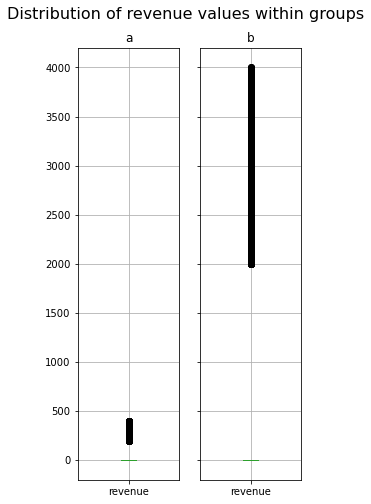

In [94]:
# building a boxplot chart (for revenue)
ab_clean.groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .95,'Distribution of revenue values ​​within groups', fontsize=16, ha='center');

Outliers are present in both groups. But it is too early to draw conclusions about their nature.

Let's look at the distribution of values ​​(descriptive statistics) for paying users.

In [95]:
# splitting into groups and counting statistics
a_paid_clean = ab_clean[(ab_clean['testgroup'] == 'a') & (ab_clean['revenue'] > 0)].revenue.describe()
b_paid_clean = ab_clean[(ab_clean['testgroup'] == 'b') & (ab_clean['revenue'] > 0)].revenue.describe()

In [96]:
# collate into one table
revenue_paid_stats_clean = pd.concat([a_paid_clean, b_paid_clean], axis=1, keys=['revenue A', 'revenue B'])

revenue_paid_stats_clean

,revenue A,revenue B
count,1805.000000,1805.000000
mean,302.458172,3003.658172
std,57.914246,572.619709
min,200.000000,2000.000000
25%,254.000000,2513.000000
50%,305.000000,3022.000000
75%,352.000000,3478.000000
max,400.000000,4000.000000


The number of paying users in groups is the same. The remaining **all(!)** indicators differ by 10 times. There is a suspicion of the artificial nature of the data of group B by multiplying the data of group A by a constant close to 10. It will be necessary to check this version in a separate study, now we will accept 

Let's take a closer look at the distribution of revenue values ​​within groups for paying users.

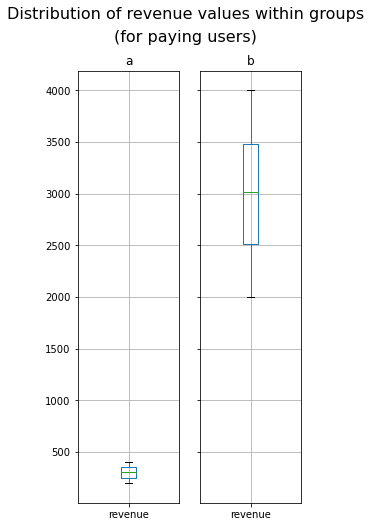

In [97]:
# building a boxplot chart (for revenue)
ab_clean[ab_clean['revenue'] > 0].groupby(['testgroup']).boxplot(column='revenue',
                                    figsize=(6, 8),
                                    layout=(1, 3));

plt.figtext(.35, .99,'Distribution of revenue values ​​within groups', fontsize=16, ha='center');
plt.figtext(.35, .95,'(for paying users)', fontsize=16, ha='center');

There are no outliers in groups A and B.

**Let's look at the distribution of revenue values ​​among paying users.**

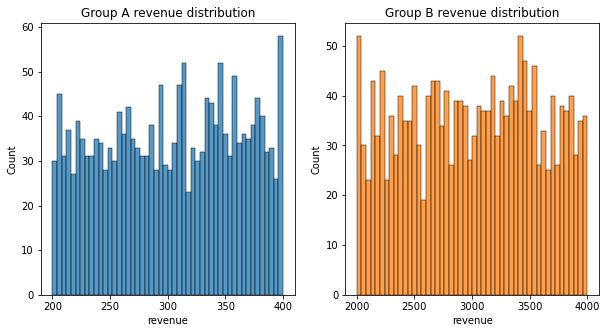

In [98]:
# mark up space for plotting
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 5)
)

# distribution histogram group A
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'a')) & (ab_clean['revenue'] > 0)],
            x='revenue', bins=50, 
            ax=ax1)
ax1.set_title('Group A revenue distribution')

# distribution histogram group B
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'b')) & (ab_clean['revenue'] > 0)],
            x='revenue', bins=50, color='#FF7F0E',
            ax=ax2)
ax2.set_title('Group B revenue distribution');

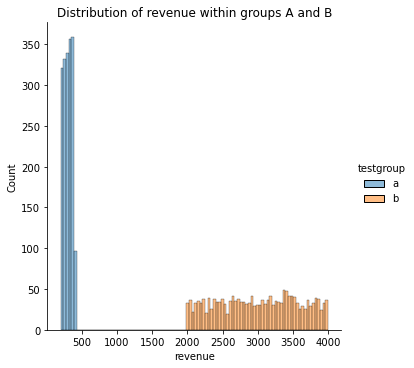

In [99]:
# display on one chart
sns.displot(data=ab_clean[ab_clean['revenue'] > 0], x='revenue', hue='testgroup', bins=100);
plt.title('Distribution of revenue within groups A and B');

The variance of group B values ​​is much higher.

**Let's check for normality**

Control group A.

In [100]:
# Shapiro-Wilk test for normality
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'a'].revenue.sample(1000, random_state=17))  # sample 1000 for test stability
alpha = 0.05  # level of statistical significance


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal.')
else:
    print('The distribution is not normal.')

test statistic = 0.0930, pvalue = 0.0000e+00
The distribution is not normal.


Control group B.

In [101]:
# Shapiro-Wilk test for normality
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'b'].revenue.sample(1000, random_state=17))   # sample 1000 for test stability
alpha = 0.05  # level of statistical significance


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal')
else:
    print('The distribution is not normal.')

test statistic = 0.0672, pvalue = 0.0000e+00
The distribution is not normal.


**Perform the Levene test for the homogeneity of variances**

In [103]:
# form samples for testing
sample_1 = ab_clean[ab_clean['testgroup'] == 'a'].revenue
sample_2 = ab_clean[ab_clean['testgroup'] == 'b'].revenue

alpha = 0.05  # level of statistical significance
# if p-value is less than it - reject the hypothesis

# test for equality of variances
lv = st.levene(sample_1, sample_2)
if lv.pvalue > alpha:
    param = True
    print('Both samples have similar variances')
else:
    print('Sample variances are different.')
    param = False

Sample variances are different.


**Perform transformation (data logarithm)*

Let's try to transform the data using logarithms in order to achieve a normal distribution of samples.

In [104]:
# Take the logarithm of the sample
ab_clean['rev_log'] = ab_clean['revenue'].apply(lambda x: np.log(x + 0.0001))  # add a constant to "do not log zeros"
ab_clean['rev_log'] = np.where(ab_clean['rev_log'] < 0, 0, ab_clean['rev_log'])  # replace back to zeros the prologarithmic values ​​of the constant

<ipython-input-104-ade8906cef9f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_clean['rev_log'] = ab_clean['revenue'].apply(lambda x: np.log(x + 0.0001))  # add a constant to "do not log zeros"
<ipython-input-104-ade8906cef9f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_clean['rev_log'] = np.where(ab_clean['rev_log'] < 0, 0, ab_clean['rev_log'])  # replace back to zeros the prologarithmic values ​​of the constant


Let's look at the distribution of revenue values ​​among paying users after taking the logarithm.

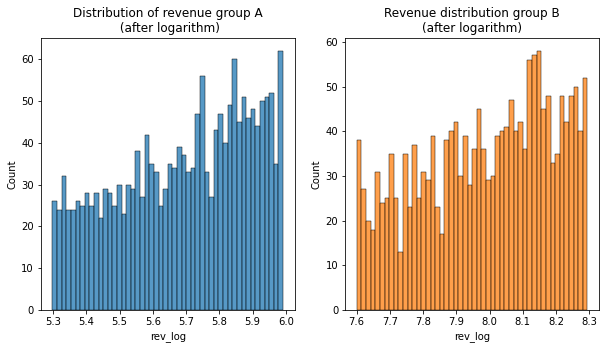

In [107]:
# mark up space for plotting
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2,
    figsize=(10, 5)
)

# distribution histogram group A
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'a')) & (ab_clean['revenue'] > 0)],
            x='rev_log', bins=50, 
            ax=ax1)
ax1.set_title('Distribution of revenue group A\n (after logarithm)')

# # distribution histogram group B
sns.histplot(data=ab_clean[((ab_clean['testgroup'] == 'b')) & (ab_clean['revenue'] > 0)],
            x='rev_log', bins=50, color='#FF7F0E',
            ax=ax2)
ax2.set_title('Revenue distribution group B\n(after logarithm)');

It cannot be said that after taking the logarithm, the distributions have assumed a normal form. To verify this, we will conduct a Shapiro-Wilk test for normality.

**Let's check for normality after taking the logarithm**

Control group A.

In [109]:
# Shapiro-Wilk test for normality
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'a'].rev_log.sample(1000, random_state=17)) 
alpha = 0.05 # level of statistical significance

print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal.')
else:
    print('The distribution is not  normal.')

test statistic = 0.0929, pvalue = 0.0000e+00
The distribution is not  normal.



Control group B.

In [110]:
# Shapiro-Wilk test for normality
result = st.shapiro(ab_clean[ab_clean['testgroup'] == 'b'].rev_log.sample(1000, random_state=17)) # sample 1000 for test stability
alpha = 0.05  # level of statistical significance


print('test statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result[1] > alpha:
    print('The distribution is normal.')
else:
    print('The distribution is not  normal.')

test statistic = 0.0666, pvalue = 0.0000e+00
The distribution is not  normal.


**Perform the Levene test for the homogeneity of variances**

In [111]:
# form samples for testing
sample_1 = ab_clean[ab_clean['testgroup'] == 'a'].rev_log
sample_2 = ab_clean[ab_clean['testgroup'] == 'b'].rev_log

alpha = 0.05 # level of statistical significance
# if p-value is less than it - reject the hypothesis

# test for equality of variances
lv = st.levene(sample_1, sample_2)
if lv.pvalue > alpha:
    param = True
    print('Both samples have similar variances')
else:
    print('Sample variances are different.')
    param = False

Sample variances are different.


#### Conclusions

The user_id column was converted to a string format, no repeated user_id values ​​were found, the split system identified users in the control and test groups approximately equally. In control group A, 123 abnormal revenue values ​​were found (possibly related to data logging errors of some users).
The samples did not pass tests for normality and homogeneity of variances. The performed transformations (logarithm) did not help to cope with this problem. The distributions of the sample values ​​are still not normal, and there is no homogeneity of the variances.

We will use the nonparametric Mann-Whitney test to further test the hypotheses.

At the next stage, we formulate the null and alternative hypotheses and compare the two samples using the nonparametric Mann-Whitney test.

### 2.4 Hypothesis testing

#### Testing the hypothesis about the equality of distributions of user revenue values

**Formulate hypotheses:**
* *Null hypothesis:* the distribution of revenue per user in the control and test groups is the same.
* *Alternative hypothesis:* the distribution of revenue per user values ​​for the control and test groups are different.

Let's conduct a non-parametric Mann-Whitney test to test hypotheses.

In [112]:
# U Mann-Whitney test of two distributions of independent samples
alpha = 0.05

result = st.mannwhitneyu(ab_clean[ab_clean['testgroup'] == 'a'].revenue,
                      ab_clean[ab_clean['testgroup'] == 'b'].revenue,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('We reject the null hypothesis that the distributions of the two samples are equal.')
else:
    print('We do not have enough reason to reject the null hypothesis and accept the alternative.')

U statistic = 20466331335.0000, pvalue = 8.6757e-01
We do not have enough reason to reject the null hypothesis and accept the alternative.


#### Testing the hypothesis about the equality of distributions of revenue values ​​from a paying user

**Formulate hypotheses:**
* *Null hypothesis:* the distribution of revenue values ​​from a paying user in the control and test groups is the same.
* *Alternative hypothesis:* the distribution of revenue per paying user in the control and test groups is different.

Let's conduct a non-parametric Mann-Whitney test to test hypotheses.

In [113]:
# U Mann-Whitney test of two distributions of independent samples
alpha = 0.05

result = st.mannwhitneyu(ab_clean[(ab_clean['testgroup'] == 'a') & (ab_clean['revenue'] > 0)].revenue,
                      ab_clean[(ab_clean['testgroup'] == 'b') & (ab_clean['revenue'] > 0)].revenue,
                      alternative='two-sided')

print('U statistic = {:.4f}, pvalue = {:.4e}'.format(result[0], result[1]))

if result.pvalue < 0.05:
    print('We reject the null hypothesis that the distributions of the two samples are equal.')
else:
    print('We do not have enough reason to reject the null hypothesis and accept the alternative.')

U statistic = 0.0000, pvalue = 0.0000e+00
We reject the null hypothesis that the distributions of the two samples are equal.


#### Testing the hypothesis about the change in conversion to purchase

**Formulate hypotheses:**
* *Null hypothesis:* the conversion to purchase of the control and test groups are the same.
* *Alternative hypothesis:* the conversion to purchase of the control and test groups are different.

In [114]:
# assign a flag for the conversion (0 - no conversion, 1 - there is a conversion)
ab_clean['conversion'] = ab_clean['revenue'].apply(lambda x: 0 if x == 0 else 1)

ab_clean

<ipython-input-114-d6871d91fedd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ab_clean['conversion'] = ab_clean['revenue'].apply(lambda x: 0 if x == 0 else 1)


,user_id,revenue,testgroup,rev_log,conversion
0,1,0,b,0.000000,0
1,2,0,a,0.000000,0
2,3,0,a,0.000000,0
3,4,0,b,0.000000,0
4,5,0,b,0.000000,0
...,...,...,...,...,...
404642,404766,0,a,0.000000,0
404643,404767,0,b,0.000000,0
404644,404768,231,a,5.442418,1
404645,404769,0,a,0.000000,0


In [115]:
# calculate the conversion for the control group
a_conv = round(ab_clean[ab_clean['testgroup'] == 'a'].conversion \
      .value_counts(normalize=True)[1] * 100, 3)

print(f'Purchase conversion for the control group is {a_conv}%.')

Purchase conversion for the control group is 0.894%.


In [116]:
# calculate the conversion for the control group
b_conv = round(ab_clean[ab_clean['testgroup'] == 'b'].conversion \
      .value_counts(normalize=True)[1] * 100, 3)

print(f'Purchase conversion for the control group is  {b_conv}%.')

Purchase conversion for the control group is  0.891%.


Let's conduct a Z-test for two samples with a Bernoulli distribution.

In [117]:
alpha = 0.05  # level of statistical significance

control = ab_clean[ab_clean['testgroup'] == 'a'].conversion
test = ab_clean[ab_clean['testgroup'] == 'b'].conversion

zscore, pvalue = proportions_ztest([sum(test), sum(control)], [len(test), len(control)],
                                   alternative = 'two-sided')
print('zscore = {:.4f}, pvalue = {:.4e}'.format(zscore, pvalue))

if pvalue <= alpha:
    print('The test result is statistically significant.')
    if test.mean() > control.mean():
        print('Purchase conversion increased in the test group.')
    else:
        print('Conversion to purchase in the test group did not increase.')
else:
    print('It was not possible to reject the null hypothesis about the equality of purchase conversions in the test and control groups and obtain a statistically significant result.')

zscore = -0.1025, pvalue = 9.1839e-01
It was not possible to reject the null hypothesis about the equality of purchase conversions in the test and control groups and obtain a statistically significant result.


#### Validate the results by running bootstrap

A function to execute and render bootstrap results.

In [119]:
def get_bootstrap(data_column_1, data_column_2, boot_it = 1000,
    statistic = np.mean, bootstrap_conf_level = 0.95):
    '''Run bootstrap and render the results.

    Parameters
    ----------
    data_column_1 : pd.Series
        The numeric values ​​of the first sample.
    data_column_2 : pd.Series
        The numeric values ​​of the second sample.
    boot_it : int
        The number of bootstrap subsamples.
        (default is 1000)
    statistic : numpy function
        Statistics we are interested in to apply
        (default is np.mean)
    bootstrap_conf_level : float
        confidence interval.
        (default is 0.95)

    returns
    -------
    plotted histogram of boot_data
        Bootstrapped data histogram
    'boot_data':
        boot_data
    'quants':
        quants
    'p_value':
        p_value
    '''
    
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # apply statistics
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = st.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = st.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
#Visualization
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title('Histogram of boot_data')
    plt.rcParams['figure.figsize'] = (12,8);
    plt.show()
       
    return {'boot_data': boot_data, 
            'quants': quants, 
            'p_value': p_value}

**Run Bootstrap to compare Average Revenue Per User (ARPU).**

**Formulate hypotheses:**
* *Null hypothesis:* the average revenue per user (ARPU) in the control and test groups is the same.
* *Alternative hypothesis:* The average revenue per user (ARPU) in the control and test groups is different.

  0%|          | 0/1000 [00:00<?, ?it/s]

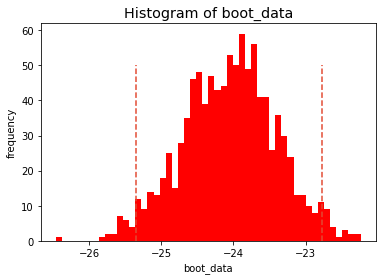

In [120]:
# run bootstrap
arpu_mean = get_bootstrap(ab_clean[ab_clean['testgroup'] == 'a'].revenue,
                          ab_clean[ab_clean['testgroup'] == 'b'].revenue,
                          statistic=np.mean)

The confidence interval does not fall into zero, the histogram "painted over" --> we have reason to reject the null hypothesis and accept the alternative one.

**Run Bootstrap to compare Average Revenue Per Paying User (ARPPU).**

**Formulate hypotheses:**
* *Null Hypothesis:* The average revenue per paying user (ARPPU) is the same in the control and test groups.
* *Alternative hypothesis:* The average revenue per paying user (ARPPU) differs between the control and test groups.

  0%|          | 0/1000 [00:00<?, ?it/s]

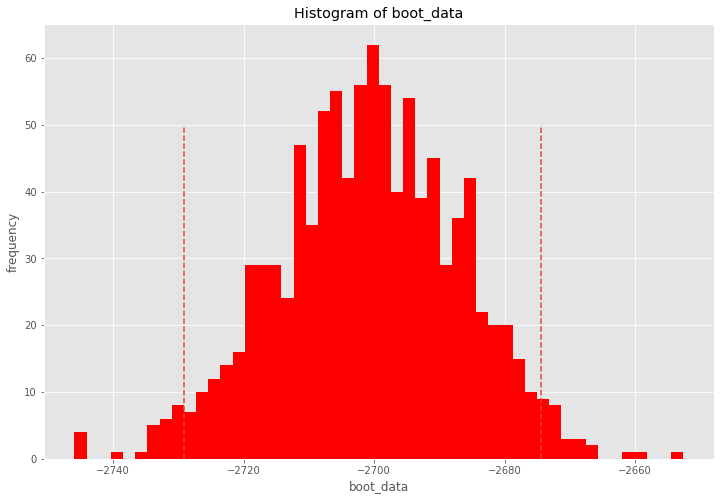

In [121]:
# run bootstrap
arppu_mean = get_bootstrap(ab_clean[(ab_clean['testgroup'] == 'a') & (ab_clean['revenue'] > 0)].revenue,
                          ab_clean[(ab_clean['testgroup'] == 'b') & (ab_clean['revenue'] > 0)].revenue,
                          statistic=np.mean)

The confidence interval does not fall into zero, the histogram "painted over" --> we have reason to reject the null hypothesis and accept the alternative one.

#### Conclusion

Five different hypotheses were tested as part of the A/B test. As a result, conversion to purchase and equality of distributions of revenue per user in the test and control groups do not have statistically significant differences, while ARPU, ARPPU, and distributions of revenue from paying users in the test and control groups are statistically significantly different.